In [1]:
import os
import pickle
import models

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from numpyro.diagnostics import hpdi

from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep.config import Config
from hbmep.model.utils import Site as site
from scipy import stats

from models import NonHierarchicalBayesianModel

USER = os.environ["USER"]


In [2]:
src = f"/home/{USER}/repos/rat-mapping-paper/reports/J_SHAP/non_hierarchical_bayesian_model/processed_inference.pkl"

with open(src, "rb") as f:
    (
        df,
        encoder_dict,
        model,
        posterior_samples,
        y,
        subjects_inv,
        compound_positions_inv,
        compound_charge_params_inv,
    ) = pickle.load(f)


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
posterior_samples[site.mu]

KeyError: 'µ'

In [3]:
encoder_dict[model.features[1]].transform(compound_positions_inv)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [4]:
compound_positions_inv

['-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L']

In [3]:
a = posterior_samples['a']
a.shape

(4000, 8, 16, 4, 6)

In [21]:
src = "/home/andres/repos/rat-mapping-paper/notebooks/J_SHAP/cath_anode_selectivity_means.pkl"
with open(src, "rb") as f:
    cathodic , anodic = pickle.load(f)

In [5]:
ind = [0,1,2,3,7,12]
labs = [compound_positions_inv[i] for i in ind]

if musc_ind == 6:
    musc = "All Muscles"
else:
    musc = model.response[musc_ind]

### ACTUAL CALCULATION
a_test = a[:,:,ind,...]
a_test = a_test / ma.median(a_test, axis = (0,2,3,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(0, 3, -1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

### GET MEAN TO PLOT
p_mean = t.mean(axis=0)
### GET P VALUES
p = test.pvalue

data = []
for ind_i, i in enumerate(p):
    for ind_j, j in enumerate(i):
        data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
        
data = np.array(data).reshape(len(ind),len(ind))

#MASK LOWER TRIANGLE
mask2= np.array(p)
mask2 = np.tril(np.ones_like(mask2)).astype(bool)

#CORRECT LABELS
labels = np.array(labs)
labels = labels.astype('U20')

#PLOT
ax=sns.heatmap(p_mean, xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


##ADD HATCH FOR SIGNIFICANCE
handles = []
hatch_mask = p > 0.1

for i in range (p.shape[0]):
    for j in range(p.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='', label="Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                    hatch='////', label="Not Significant"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                    hatch='', label="Row Element Lower Threshold"))
handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                    hatch='', label="Row Element Higher Threshold"))
ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
        handlelength=2, handleheight=2, frameon=False)
ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

ax.yaxis.tick_right()
ax.title.set_text(f"{musc}")


NameError: name 'musc_ind' is not defined

In [6]:
compound_positions_inv

['-C6L',
 '-C7L',
 '-C8L',
 'C6L-',
 'C6L-C6M',
 'C6L-C7L',
 'C6M-C6L',
 'C7L-',
 'C7L-C6L',
 'C7L-C7M',
 'C7L-C8L',
 'C7M-C7L',
 'C8L-',
 'C8L-C7L',
 'C8L-C8M',
 'C8M-C8L']

In [14]:
def threshold_plot(musc_ind):
    ind = [0,1,2,3,7,12]
    labs = [compound_positions_inv[i] for i in ind]



    if musc_ind == 6:
        musc = "All Muscles"  
    ### ACTUAL CALCULATION
        a_test = a[:,:,ind,...]
        a_test = a_test / ma.median(a_test, axis = (0,2,3,-1), keepdims=True)

        a_mean = ma.mean(a_test, axis=(0, 3, -1))
        a_mean.shape

        t = (a_mean[:, :, None] - a_mean[:, None, :])
        test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

    ### GET MEAN TO PLOT
        p_mean = t.mean(axis=0)
    ### GET P VALUES
        p = test.pvalue

    else:
        musc = model.response[musc_ind]
        
        a_test = a[:,:,ind,...]
        a_test = a_test[...,0]
        a_test.shape

        a_test = a_test / ma.median(a_test, keepdims=True)

        a_mean = ma.mean(a_test, axis=(0,-1))
        a_mean.shape

        t = (a_mean[:, :, None] - a_mean[:, None, :])
        test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

        #     ### GET MEAN TO PLOT
        p_mean = t.mean(axis=0)
        p = test.pvalue


    data = []
    for ind_i, i in enumerate(p):
        for ind_j, j in enumerate(i):
            data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
            
    data = np.array(data).reshape(len(ind),len(ind))

    #MASK LOWER TRIANGLE
    mask2= np.array(p)
    mask2 = np.tril(np.ones_like(mask2)).astype(bool)

    #CORRECT LABELS
    labels = np.array(labs)
    labels = labels.astype('U20')

    #PLOT
    ax=sns.heatmap(p_mean, xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


    ##ADD HATCH FOR SIGNIFICANCE
    handles = []
    hatch_mask = p > 0.1

    for i in range (p.shape[0]):
        for j in range(p.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    ax.title.set_text(f"{musc}")

/tmp/ipykernel_3113991/4220659606.py:47: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")


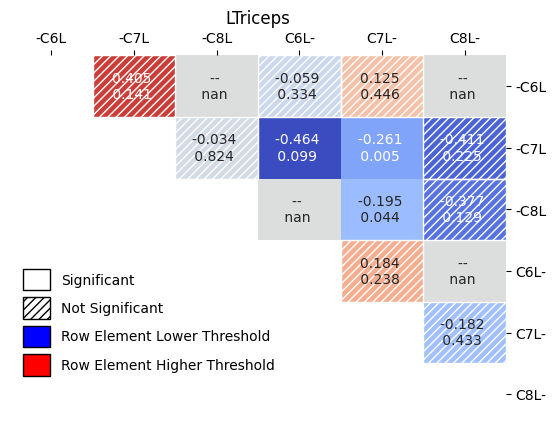

In [15]:
threshold_plot(5)

In [16]:
ind = [0,1,2,3,7,12]
a[:,:,ind,...].shape

(4000, 8, 6, 4, 6)

In [17]:
mono = a[:,:,ind,1,:]

In [19]:
mono = mono / ma.median(mono, axis = (0,2,3), keepdims=True)

In [20]:
mono.shape

(4000, 8, 6, 6)

In [ ]:
cathodic , anodic

In [ ]:
cath_ind = (0,1,2)

In [25]:
cathodic_eff = mono[...,:3,:]
anodic_eff = mono[...,3:,:]

In [31]:
cathodic_eff_subs = ma.mean(cathodic_eff, axis=(0, 2, -1))
anodic_eff_subs = ma.mean(anodic_eff, axis=(0, 2, -1))

In [45]:
cathodic_eff_subs

masked_array(data=[0.9222286110444978, 0.9656646008063852,
                   0.8597894464146333, 0.765771912703315,
                   0.3879232416373475, 0.5174997966827297,
                   0.5528168947471723, 0.6140530004397401],
             mask=[False, False, False, False, False, False, False, False],
       fill_value=1e+20)

In [46]:
cathodic_eff_mean = ma.mean(cathodic_eff_subs)
cathodic_eff_sem = stats.sem(cathodic_eff_subs)

anodic_eff_mean = ma.mean(anodic_eff_subs)
anodic_eff_sem = stats.sem(anodic_eff_subs)

In [49]:
cathodic_sel_mean = ma.mean(cathodic)
cathodic_sel_sem = stats.sem(cathodic)
anodic_sel_mean = ma.mean(anodic)
anodic_sel_sem = stats.sem(anodic)

In [50]:
cathodic_sel_sem

43.68152303318423

In [51]:
combo_eff = np.array([cathodic_eff_mean, anodic_eff_mean])
combo_sel = np.array([cathodic_sel_mean, anodic_sel_mean])
sem_eff = np.array([cathodic_eff_sem, anodic_eff_sem])
sem_sel = np.array([cathodic_sel_sem, anodic_sel_sem])

In [54]:
1/combo_eff

array([1.43221655, 0.63923716])

Text(0.5, 0, 'Normalized Efficacy')

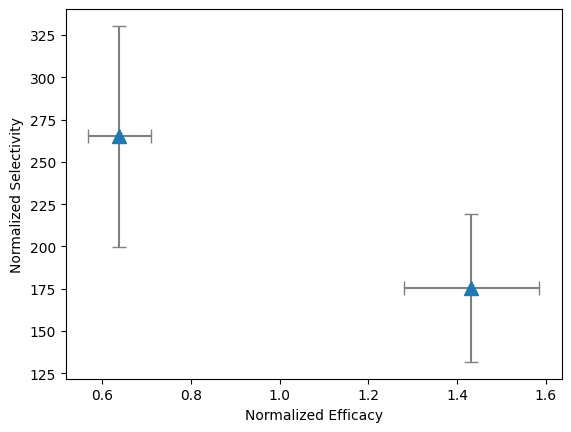

In [53]:
plt.errorbar(x = 1/combo_eff, y = combo_sel, xerr = (sem_eff/combo_eff**2), yerr= sem_sel,fmt='^', capsize=5,ms = 10, ecolor='gray')
plt.ylabel("Normalized Selectivity")
plt.xlabel("Normalized Efficacy")

In [9]:
def pulse_shape(musc_ind):
    ind = [0,1,2]
    labs = compound_charge_params_inv


    if musc_ind == 6:
        musc = "All Muscles"  
    ### ACTUAL CALCULATION
        a_test = a[:,:,ind,...]
        a_test = a_test / ma.median(a_test, axis = (0,2,3,-1), keepdims=True)

        a_mean = ma.mean(a_test, axis=(0, 2, -1))
        a_mean.shape

        t = (a_mean[:, :, None] - a_mean[:, None, :])
        test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

    ### GET MEAN TO PLOT
        p_mean = t.mean(axis=0)
    ### GET P VALUES
        p = test.pvalue

    else:
        musc = model.response[musc_ind]
        
        a_test = a[:,:,ind,...]
        a_test = a_test[...,0]
        a_test.shape

        a_test = a_test / ma.median(a_test, keepdims=True)

        a_mean = ma.mean(a_test, axis=(0,-1))
        a_mean.shape

        t = (a_mean[:, :, None] - a_mean[:, None, :])
        test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

        #     ### GET MEAN TO PLOT
        p_mean = t.mean(axis=0)
        p = test.pvalue


    data = []
    for ind_i, i in enumerate(p):
        for ind_j, j in enumerate(i):
            data.append(f"{p_mean[ind_i, ind_j]:.3f} \n {j:.3f}  ")
            
    data = np.array(data).reshape(len(labs),len(labs))

    #MASK LOWER TRIANGLE
    mask2= np.array(p)
    mask2 = np.tril(np.ones_like(mask2)).astype(bool)

    #CORRECT LABELS
    labels = np.array(labs)
    labels = labels.astype('U20')

    #PLOT
    ax=sns.heatmap(p_mean, xticklabels=labels, yticklabels=labels,annot=data,fmt = '',center = 0, cmap = "coolwarm",cbar = False, mask = mask2)


    ##ADD HATCH FOR SIGNIFICANCE
    handles = []
    hatch_mask = p > 0.1

    for i in range (p.shape[0]):
        for j in range(p.shape[1]):
            if hatch_mask[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, hatch='////', edgecolor='white'))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='', label="Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='white', ec='black',
                        hatch='////', label="Not Significant"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='blue', ec='black',
                        hatch='', label="Row Element Lower Threshold"))
    handles.append(plt.Rectangle((0, 0), 0, 0, color='Red', ec='black',
                        hatch='', label="Row Element Higher Threshold"))
    ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0, .1),
            handlelength=2, handleheight=2, frameon=False)
    ax.tick_params(left= False,labelleft = False, bottom= False,labelbottom= False,right=True, top=True, labelright=True, labeltop=True, labelrotation=0)

    ax.yaxis.tick_right()
    ax.title.set_text(f"Threshold comparison between pulse shapes")

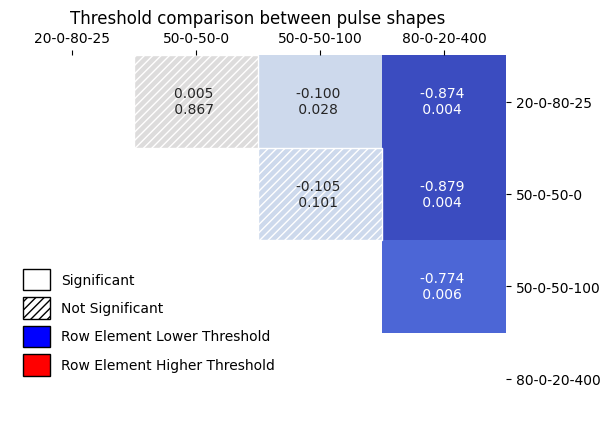

In [10]:
pulse_shape(6)

In [36]:
a_test = a[:,:,ind,...]
a_test = a_test / ma.median(a_test, axis = (0,2,3,-1), keepdims=True)

a_mean = ma.mean(a_test, axis=(0, 2, -1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

In [7]:
a_test = a[:,:,ind,...]
a_test = a_test[...,0]
a_test.shape

a_test = a_test / ma.median(a_test, keepdims=True)

a_mean = ma.mean(a_test, axis=(0,-1))
a_mean.shape

t = (a_mean[:, :, None] - a_mean[:, None, :])
test = stats.ttest_1samp(t, popmean=0, alternative="two-sided", axis=(0))

#     ### GET MEAN TO PLOT
p_mean = t.mean(axis=0)

In [ ]:
a.shape